In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dolfin import *
import ulfy

import matplotlib.pyplot as plt
import sympy as sp
import numpy as np

In [3]:
def simpleplot(u, **kwargs):
    c = plot(u, **kwargs)
    plt.colorbar(c)
    plt.show()

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


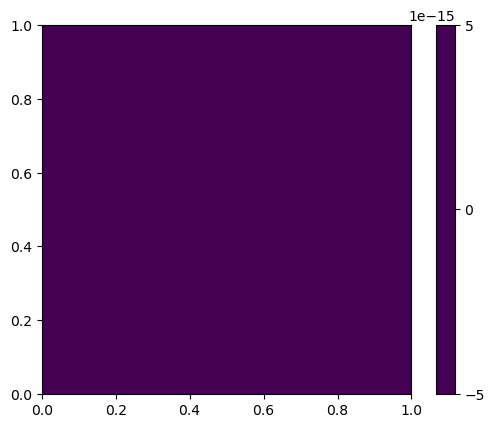

Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.1 : 1.2078866386498768e-15
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.2 : 2.6597772711514633e-15
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.30000000000000004 : 4.1944991862163446e-15
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.4 : 5.646022228686674e-15
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solvi

In [4]:
# Diffusion coefficient
D = 2.0

# Placeholder for sympy-generated expressions
mesh_ = UnitSquareMesh(1, 1)
V_ = FunctionSpace(mesh_, "CG", 1)
u_ = Function(V_)
dudt_ = Function(V_)

# Define time here.
T = 1.0
dt = 0.1
time = Constant(0.0)

# Sympy-generated MMS solutions
x, y, t = sp.symbols("x y t")
u_sympy = t * (x**2 + y**2)
u_mms = ulfy.Expression(u_, subs={u_: u_sympy}, degree=2, t=time)
f_mms = ulfy.Expression(dudt_ + div(-D*grad(u_)), subs={u_: u_sympy, dudt_: sp.diff(u_sympy, t)}, degree=2, t=time)

u_expr = Expression(f"t * (x[0]*x[0] + x[1]*x[1])", degree=2, t=time)
f_expr = Expression(f"(x[0]*x[0] + x[1]*x[1]) - 4*{D}*t", degree=2, t=time)


# Define which of the formulations for u, f we should use
f = f_mms
u_true = u_mms
# f = f_expr
# u_true = u_expr

# Define deomain and
n = 20
domain = UnitSquareMesh(n, n)
V = FunctionSpace(domain, "CG", 2)

u0 = project(u_true, V)
bcs = [DirichletBC(V, u_true, "on_boundary")]

u = TrialFunction(V)
v = TestFunction(V)

F = ((u - u0)*v + dt * (inner(D*grad(u), grad(v)) - f*v)) * dx
# a = (u * v + dt * inner(D*grad(u), grad(v))) * dx
# l = (u0)
a = lhs(F)
l = rhs(F)

N = int(np.ceil(T / dt) + 1)
errors = np.nan * np.zeros(N)
idx = 0
time.assign(0.0)

uh = Function(V)
uh.assign(u0)
errors[idx] = errornorm(u_true, uh)
simpleplot(uh, mesh=domain, vmax=2)
time.assign(time + dt)
while float(time) < T:
    idx += 1
    solve(a==l, uh, bcs=bcs)
    print(float(time), ":", errornorm(u_true, uh))
    errors[idx] = errornorm(u_true, uh, degree_rise=4)
#     simpleplot(uh, mesh=domain, vmax=2)
    time.assign(time + dt)
    u0.assign(uh)

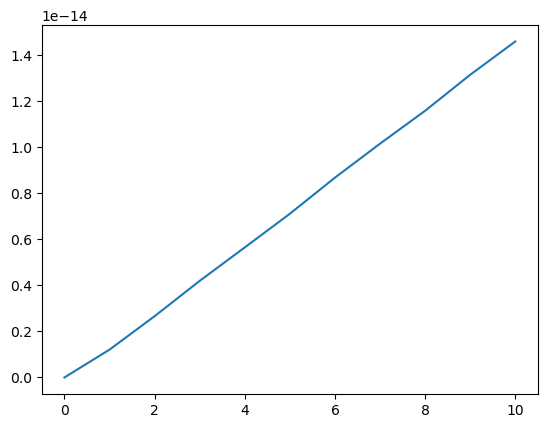

In [21]:
plt.plot(errors)